<a href="https://colab.research.google.com/github/andreworba01/IAFP_2026_Competition/blob/main/ML_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IAFP 2026 Competition Notebook




In [9]:
# If you're running in Google Colab and your data is on Drive, uncomment:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score, accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC

# Optional: LightGBM & CatBoost (if installed)
try:
    from lightgbm import LGBMClassifier
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

try:
    from catboost import CatBoostClassifier
    HAS_CAT = True
except Exception:
    HAS_CAT = False

RANDOM_STATE = 142
np.random.seed(RANDOM_STATE)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip -q install catboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 27.9 MB/s eta 0:00:00


## 1) Load data + create label
Set `DATA_PATH` to your file. The code creates `label` where **1 = presence** (isolate count > 0).

In [11]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/IAFP2026/ListeriaSoil_clean.csv"   # <-- change if needed (e.g., "/content/drive/MyDrive/.../ListeriaSoil_clean.csv")

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)

TARGET_COUNT_COL = "Number of Listeria isolates obtained"
assert TARGET_COUNT_COL in df.columns, f"Missing expected column: {TARGET_COUNT_COL}"

df["label"] = (df[TARGET_COUNT_COL] > 0).astype(int)
print("\nLabel balance:\n", df["label"].value_counts(), "\n", df["label"].value_counts(normalize=True))

# Features: drop the raw count to avoid leakage
X = df.drop(columns=["label", TARGET_COUNT_COL])
y = df["label"]

missing = X.isna().mean().sort_values(ascending=False)
print("\nTop missingness:\n", missing.head(10))


Shape: (622, 35)

Label balance:
 label
1    311
0    311
Name: count, dtype: int64 
 label
1    0.5
0    0.5
Name: proportion, dtype: float64

Top missingness:
 Latitude              0.0
Longitude             0.0
Elevation (m)         0.0
Moisture              0.0
Total nitrogen (%)    0.0
Total carbon (%)      0.0
pH                    0.0
Organic matter (%)    0.0
Aluminum (mg/Kg)      0.0
Calcium (mg/Kg)       0.0
dtype: float64


## 2) Train/test split (hold-out)
We keep a hold-out set for a final report, but rely on **Repeated CV** for reliable model selection.

In [30]:
from sklearn.model_selection import train_test_split

# Optional: define if not already set
RANDOM_STATE = 42

# Quick sanity checks (will raise clear errors if X/y aren't defined yet)
print("X shape:", getattr(X, "shape", None))
print("y shape:", getattr(y, "shape", None))

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)



X shape: (622, 34)
y shape: (622,)


In [31]:
import numpy as np

print("Pos rate train:", float(np.mean(y_train)))
print("Pos rate test :", float(np.mean(y_test)))


Pos rate train: 0.5010060362173038
Pos rate test : 0.496


##Threshold selection + confusion-matrix summary from predicted probabilities

In [32]:
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_curve

def confusion_table_from_proba(y_true, y_proba, threshold, model_name="model"):
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sens = tp / (tp + fn) if (tp + fn) else 0.0  # Recall/Sensitivity
    spec = tn / (tn + fp) if (tn + fp) else 0.0  # Specificity
    bal_acc = 0.5 * (sens + spec)
    return pd.DataFrame([{
        "Model": model_name,
        "Threshold": threshold,
        "TN": tn, "FP": fp, "FN": fn, "TP": tp,
        "Sensitivity (Recall)": sens,
        "Specificity": spec,
        "Balanced Accuracy": bal_acc
    }])

def threshold_for_min_recall(y_true, y_proba, target_recall=0.90):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    ok = np.where(recall[:-1] >= target_recall)[0]   # thresholds aligns with recall[:-1]
    return thresholds[ok[-1]] if len(ok) else 0.0


In [33]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


In [34]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

def make_pipe(model, scale=False):
    steps = [("imputer", SimpleImputer(strategy="median"))]
    if scale:
        steps += [("scaler", StandardScaler())]
    steps += [("model", model)]
    return Pipeline(steps)


###Define candidate models for benchmarking (with class balancing + scaling flag)

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC

models = {
    "LogReg (balanced)": (LogisticRegression(max_iter=5000, class_weight="balanced"), True),
    "SVM-RBF (balanced)": (SVC(probability=True, class_weight="balanced", C=2.0, gamma="scale"), True),
    "RF (balanced)": (RandomForestClassifier(
        n_estimators=700, class_weight="balanced_subsample",
        min_samples_leaf=2, random_state=42, n_jobs=-1
    ), False),
    "ExtraTrees (balanced)": (ExtraTreesClassifier(
        n_estimators=900, class_weight="balanced",
        min_samples_leaf=2, random_state=42, n_jobs=-1
    ), False),
    "HistGB": (HistGradientBoostingClassifier(
        max_depth=6, learning_rate=0.05, max_iter=400, random_state=42
    ), False),
}


###Add optional gradient-boosting models (LightGBM + CatBoost) with silent output

In [36]:
# LightGBM
try:
    from lightgbm import LGBMClassifier
    models["LightGBM (recall-leaning)"] = (LGBMClassifier(
        n_estimators=1400,
        learning_rate=0.03,
        num_leaves=64,
        verbosity=-1,
        min_child_samples=10,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42
        # If imbalance is strong, consider:
        # is_unbalance=True
        # OR scale_pos_weight=...
    ), False)
except Exception as e:
    print("LightGBM not available:", e)

# CatBoost
try:
    from catboost import CatBoostClassifier
    models["CatBoost (recall-leaning)"] = (CatBoostClassifier(
        iterations=2000,
        learning_rate=0.03,
        depth=7,
        loss_function="Logloss",
        random_strength=1.0,
        subsample=0.8,
        rsm=0.8,                 # feature subsampling
        auto_class_weights="Balanced",  # helps reduce FN tendency
        verbose=0,
        random_seed=42
    ), False)
except Exception as e:
    print("CatBoost not available:", e)


###Compute out-of-fold (OOF) predicted probabilities for all models (cross_val_predict)

In [37]:
from sklearn.model_selection import cross_val_predict

oof_proba = {}   # p_train per model
pipes = {}       # fitted pipes per model

for name, (model, scale) in models.items():
    pipe = make_pipe(model, scale=scale)
    p_oof = cross_val_predict(pipe, X_train, y_train, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
    oof_proba[name] = p_oof
    pipes[name] = pipe

print("OOF models computed:", list(oof_proba.keys())[:5], "...")


OOF models computed: ['LogReg (balanced)', 'SVM-RBF (balanced)', 'RF (balanced)', 'ExtraTrees (balanced)', 'HistGB'] ...


##Threshold selection for target recall (OOF)
####We set decision thresholds to meet a target recall (e.g., ≥0.90) because false negatives pose higher public-health risk than false positives in food safety screening.

In [38]:
TARGET_RECALL = 0.90  # try 0.95 or even 0.98 if you REALLY want no FN

chosen_thresholds = {}
for name, p_train in oof_proba.items():
    thr = threshold_for_min_recall(y_train, p_train, target_recall=TARGET_RECALL)
    chosen_thresholds[name] = thr

pd.Series(chosen_thresholds).sort_values()


,0
HistGB,0.198421
LightGBM (recall-leaning),0.261349
SVM-RBF (balanced),0.307001
LogReg (balanced),0.321854
RF (balanced),0.457408
ExtraTrees (balanced),0.469331
CatBoost (recall-leaning),0.495447


In [39]:
from sklearn.metrics import roc_auc_score, average_precision_score

rows = []

for name, (model, scale) in models.items():
    pipe = make_pipe(model, scale=scale)
    pipe.fit(X_train, y_train)
    p_test = pipe.predict_proba(X_test)[:, 1]

    thr = chosen_thresholds[name]
    tab = confusion_table_from_proba(y_test, p_test, threshold=thr, model_name=name)

    tab["ROC AUC"] = roc_auc_score(y_test, p_test)
    tab["Avg Precision"] = average_precision_score(y_test, p_test)
    tab["Chosen Thr (from OOF)"] = thr

    rows.append(tab)

results = pd.concat(rows, ignore_index=True)
results.sort_values(["FN","FP","ROC AUC"], ascending=[True, True, False])


,Model,Threshold,TN,FP,FN,TP,Sensitivity (Recall),Specificity,Balanced Accuracy,ROC AUC,Avg Precision,Chosen Thr (from OOF)
0,LogReg (balanced),0.321854,42,21,2,60,0.967742,0.666667,0.817204,0.890169,0.833814,0.321854
1,SVM-RBF (balanced),0.307001,41,22,4,58,0.935484,0.650794,0.793139,0.906298,0.906705,0.307001
4,HistGB,0.198421,56,7,5,57,0.919355,0.888889,0.904122,0.958013,0.962916,0.198421
5,LightGBM (recall-leaning),0.261349,55,8,6,56,0.903226,0.873016,0.888121,0.960573,0.960990,0.261349
3,ExtraTrees (balanced),0.469331,50,13,6,56,0.903226,0.793651,0.848438,0.920123,0.931038,0.469331
6,CatBoost (recall-leaning),0.495447,58,5,7,55,0.887097,0.920635,0.903866,0.965438,0.970190,0.495447
2,RF (balanced),0.457408,53,10,8,54,0.870968,0.841270,0.856119,0.940348,0.944795,0.457408


In [40]:
cols = ["Model","Chosen Thr (from OOF)","TN","FP","FN","TP",
        "Sensitivity (Recall)","Specificity","Balanced Accuracy","ROC AUC","Avg Precision"]
results[cols].sort_values(["FN","FP","Sensitivity (Recall)"], ascending=[True, True, False])


,Model,Chosen Thr (from OOF),TN,FP,FN,TP,Sensitivity (Recall),Specificity,Balanced Accuracy,ROC AUC,Avg Precision
0,LogReg (balanced),0.321854,42,21,2,60,0.967742,0.666667,0.817204,0.890169,0.833814
1,SVM-RBF (balanced),0.307001,41,22,4,58,0.935484,0.650794,0.793139,0.906298,0.906705
4,HistGB,0.198421,56,7,5,57,0.919355,0.888889,0.904122,0.958013,0.962916
5,LightGBM (recall-leaning),0.261349,55,8,6,56,0.903226,0.873016,0.888121,0.960573,0.960990
3,ExtraTrees (balanced),0.469331,50,13,6,56,0.903226,0.793651,0.848438,0.920123,0.931038
6,CatBoost (recall-leaning),0.495447,58,5,7,55,0.887097,0.920635,0.903866,0.965438,0.970190
2,RF (balanced),0.457408,53,10,8,54,0.870968,0.841270,0.856119,0.940348,0.944795


####Plot ROC curves and AUC for all models on the test set

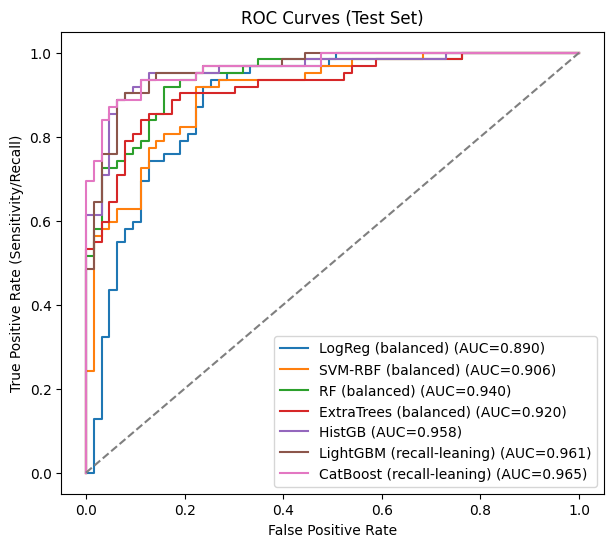

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure(figsize=(7,6))

for name, (model, scale) in models.items():
    pipe = make_pipe(model, scale=scale)
    pipe.fit(X_train, y_train)
    p_test = pipe.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, p_test)
    auc = roc_auc_score(y_test, p_test)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Sensitivity/Recall)")
plt.title("ROC Curves (Test Set)")
plt.legend()
plt.show()


In [42]:
# ---- Select best model (from prior comparison) ----
best_model = "HistGB"

# Optional safety check
if best_model not in oof_proba:
    raise KeyError(f"{best_model} not found in oof_proba. Available: {list(oof_proba.keys())}")


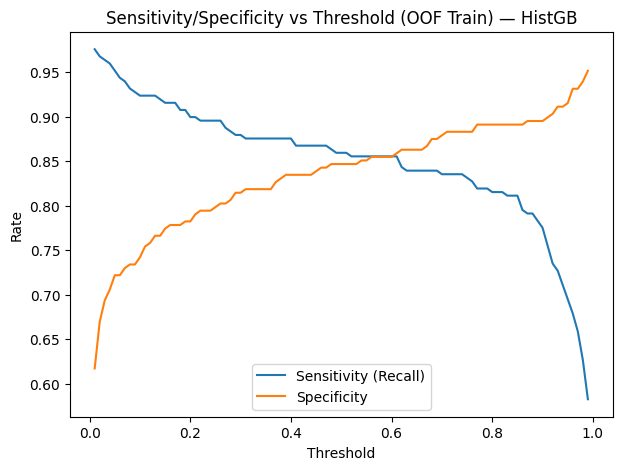

In [43]:
# Refit best model and analyze threshold curve on TRAIN OOF
p_train = oof_proba[best_model]
thresholds = np.linspace(0.01, 0.99, 99)

sens_list, spec_list, fn_list, fp_list = [], [], [], []

from sklearn.metrics import confusion_matrix

for t in thresholds:
    tn, fp, fn, tp = confusion_matrix(y_train, (p_train >= t).astype(int)).ravel()
    sens = tp/(tp+fn) if (tp+fn) else 0.0
    spec = tn/(tn+fp) if (tn+fp) else 0.0
    sens_list.append(sens); spec_list.append(spec)
    fn_list.append(fn); fp_list.append(fp)

plt.figure(figsize=(7,5))
plt.plot(thresholds, sens_list, label="Sensitivity (Recall)")
plt.plot(thresholds, spec_list, label="Specificity")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title(f"Sensitivity/Specificity vs Threshold (OOF Train) — {best_model}")
plt.legend()
plt.show()


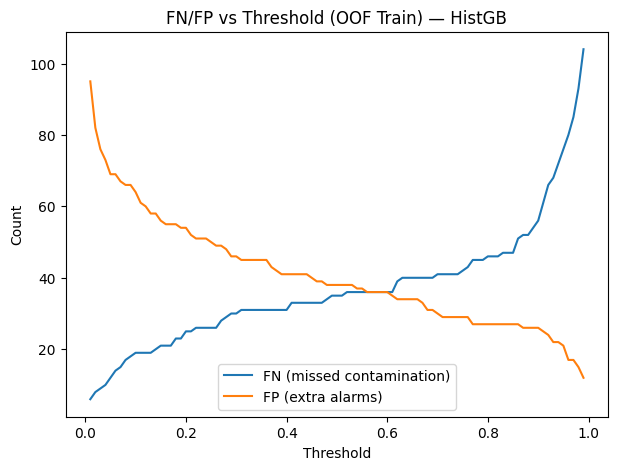

In [44]:
plt.figure(figsize=(7,5))
plt.plot(thresholds, fn_list, label="FN (missed contamination)")
plt.plot(thresholds, fp_list, label="FP (extra alarms)")
plt.xlabel("Threshold")
plt.ylabel("Count")
plt.title(f"FN/FP vs Threshold (OOF Train) — {best_model}")
plt.legend()
plt.show()


#improve HistGB + LightGBM

In [45]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, roc_curve, precision_recall_curve
)

RANDOM_STATE = 42

def make_pipe(model, scale=False):
    if scale:
        return Pipeline([("scaler", StandardScaler()), ("model", model)])
    return Pipeline([("model", model)])

# If you haven't defined cv yet:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)



In [46]:
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = neg / max(pos, 1)

print("Train positives:", pos, "negatives:", neg, "scale_pos_weight:", scale_pos_weight)



Train positives: 249 negatives: 248 scale_pos_weight: 0.9959839357429718


In [47]:
from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMClassifier

histgb_base = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=6,
    max_iter=600,
    min_samples_leaf=10,
    l2_regularization=1.0,
    random_state=RANDOM_STATE,
    early_stopping=True
)

lgbm_base = LGBMClassifier(
    n_estimators=2500,
    learning_rate=0.02,
    num_leaves=64,
    min_child_samples=10,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=2.0,
    reg_alpha=0.0,
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight,
    n_jobs=-1
)

pipes_2 = {
    "HistGB (improved base)": make_pipe(histgb_base, scale=False),
    "LightGBM (improved base)": make_pipe(lgbm_base, scale=False),
}


##Tune HistGB (small randomized search, fast-ish, robust)
####Hyperparameter tuning for HistGradientBoosting (RandomizedSearchCV on train CV, ROC-AUC scoring)

In [48]:
histgb_param = {
    "model__learning_rate": [0.03, 0.05, 0.08],
    "model__max_depth": [3, 5, 6, 8],
    "model__max_iter": [400, 600, 900],
    "model__min_samples_leaf": [5, 10, 20, 40],
    "model__l2_regularization": [0.0, 0.5, 1.0, 3.0, 10.0],
    "model__max_bins": [128, 255],
}

histgb_search = RandomizedSearchCV(
    estimator=pipes_2["HistGB (improved base)"],
    param_distributions=histgb_param,
    n_iter=20,
    scoring="roc_auc",
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

histgb_search.fit(X_train, y_train)
print("Best HistGB ROC AUC:", histgb_search.best_score_)
print("Best HistGB params:", histgb_search.best_params_)


Best HistGB ROC AUC: 0.9197240816326531
Best HistGB params: {'model__min_samples_leaf': 5, 'model__max_iter': 400, 'model__max_depth': 8, 'model__max_bins': 255, 'model__learning_rate': 0.05, 'model__l2_regularization': 1.0}


##Tune LightGBM (recall-leaning search)

In [ ]:
lgbm_param = {
    "model__n_estimators": [1500, 2500, 3500],
    "model__learning_rate": [0.01, 0.02, 0.03],
    "model__num_leaves": [31, 63, 127],
    "model__min_child_samples": [5, 10, 20, 40],
    "model__subsample": [0.7, 0.85, 0.95],
    "model__colsample_bytree": [0.7, 0.85, 0.95],
    "model__reg_lambda": [0.5, 1.0, 2.0, 5.0, 10.0],
    "model__reg_alpha": [0.0, 0.1, 0.5, 1.0],
}

lgbm_search = RandomizedSearchCV(
    estimator=pipes_2["LightGBM (improved base)"],
    param_distributions=lgbm_param,
    n_iter=25,
    scoring="roc_auc",
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

lgbm_search.fit(X_train, y_train)
print("Best LightGBM ROC AUC:", lgbm_search.best_score_)
print("Best LightGBM params:", lgbm_search.best_params_)


##Final tuned pipelines

In [ ]:
best_histgb = histgb_search.best_estimator_
best_lgbm   = lgbm_search.best_estimator_

final_pipes = {
    "HistGB (tuned)": best_histgb,
    "LightGBM (tuned)": best_lgbm
}


In [ ]:
oof_proba_2 = {}
for name, pipe in final_pipes.items():
    p_oof = cross_val_predict(pipe, X_train, y_train, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
    oof_proba_2[name] = p_oof

list(oof_proba_2.keys()), {k: (v.min(), v.max()) for k,v in oof_proba_2.items()}


##Threshold picker for “minimum FN”

In [ ]:
def threshold_for_min_recall(y_true, p, target_recall=0.95):
    precision, recall, thresholds = precision_recall_curve(y_true, p)
    ok = np.where(recall[:-1] >= target_recall)[0]
    if len(ok) == 0:
        return 0.0
    return thresholds[ok[-1]]

TARGET_RECALL = 0.97  # try 0.98 / 0.99 if you want even fewer FN

chosen_thr_2 = {
    name: threshold_for_min_recall(y_train, p_oof, target_recall=TARGET_RECALL)
    for name, p_oof in oof_proba_2.items()
}
pd.Series(chosen_thr_2).sort_values()


##Fit on full train, predict proba on test, performance table (FN/FP-focused)

In [ ]:
rows = []

for name, pipe in final_pipes.items():
    pipe.fit(X_train, y_train)
    p_test = pipe.predict_proba(X_test)[:, 1]
    thr = chosen_thr_2[name]
    yhat = (p_test >= thr).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, yhat).ravel()
    recall = tp/(tp+fn) if (tp+fn) else 0.0
    spec   = tn/(tn+fp) if (tn+fp) else 0.0
    balacc = 0.5*(recall + spec)

    rows.append({
        "Model": name,
        "Chosen Thr (from OOF)": thr,
        "TN": tn, "FP": fp, "FN": fn, "TP": tp,
        "Sensitivity (Recall)": recall,
        "Specificity": spec,
        "Balanced Accuracy": balacc,
        "ROC AUC": roc_auc_score(y_test, p_test),
        "Avg Precision": average_precision_score(y_test, p_test)
    })

perf_2 = pd.DataFrame(rows).sort_values(["FN","FP","ROC AUC"])
perf_2


##ROC curves (HistGB vs LightGBM tuned)

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
for name, pipe in final_pipes.items():
    pipe.fit(X_train, y_train)
    p_test = pipe.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, p_test)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, p_test):.3f})")

plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive) Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves (Test Set)")
plt.legend()
plt.show()


##Path B — Feature selection (gives you “best variables” you can explain)

In [ ]:
# This extracts the expanded feature names (numeric + one-hot)
feature_names = []

# numeric names
feature_names.extend(num_cols2)

# categorical one-hot names
if len(cat_cols2) > 0:
    ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
    cat_feat = ohe.get_feature_names_out(cat_cols2).tolist()
    feature_names.extend(cat_feat)

print("Total transformed features:", len(feature_names))


In [ ]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=1e-6)
Xtr_v = vt.fit_transform(Xtr)
Xte_v = vt.transform(Xte)

kept_mask = vt.get_support()
kept_features = np.array(feature_names)[kept_mask]

print("After variance filter:", Xtr_v.shape[1], "features kept")
print("Example kept features:", kept_features[:20])


In [ ]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=1e-6)
Xtr_v = vt.fit_transform(Xtr)
Xte_v = vt.transform(Xte)

kept_mask = vt.get_support()
kept_features = np.array(feature_names)[kept_mask]

print("After variance filter:", Xtr_v.shape[1], "features kept")
print("Example kept features:", kept_features[:20])


In [ ]:
from sklearn.feature_selection import mutual_info_classif

# mutual information expects dense sometimes; keep safe
Xtr_dense = Xtr_v.toarray() if hasattr(Xtr_v, "toarray") else Xtr_v

mi = mutual_info_classif(Xtr_dense, y_train, random_state=42)
mi_series = pd.Series(mi, index=kept_features).sort_values(ascending=False)

mi_series.head(25)


In [ ]:
from sklearn.base import clone

Ks = [10, 20, 30, 50, 80, 120, 200]
Ks = [k for k in Ks if k < Xtr_v.shape[1]]

rows = []
for k in Ks:
    topk = mi_series.index[:k]
    idx = np.where(np.isin(kept_features, topk))[0]

    Xtr_k = (Xtr_v[:, idx]).toarray() if hasattr(Xtr_v[:, idx], "toarray") else (Xtr_v[:, idx])
    Xte_k = (Xte_v[:, idx]).toarray() if hasattr(Xte_v[:, idx], "toarray") else (Xte_v[:, idx])

    # OOF for threshold
    p_oof = cross_val_predict(clone(clf), Xtr_k, y_train, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
    thr = threshold_max_spec_given_recall(y_train, p_oof, target_recall=TARGET_RECALL)

    # fit & test
    m = clone(clf).fit(Xtr_k, y_train)
    p_test = m.predict_proba(Xte_k)[:, 1]

    tn, fp, fn, tp, rec, spec, bal = eval_model_probs(y_test, p_test, thr)
    rows.append([k, thr, fn, fp, rec, spec, bal, roc_auc_score(y_test, p_test), average_precision_score(y_test, p_test)])

fs_results = pd.DataFrame(rows, columns=["TopK","thr","FN","FP","Recall","Specificity","BalancedAcc","ROC_AUC","AvgPrecision"])
fs_results.sort_values(["FN","Recall","ROC_AUC"], ascending=[True, False, False])


In [ ]:
best_row = fs_results.sort_values(["FN","Recall","Specificity"], ascending=[True, False, False]).iloc[0]
best_k = int(best_row["TopK"])
top_features = mi_series.index[:best_k].tolist()

print("Chosen K:", best_k)
print("Metrics:\n", best_row)
print("\nTop selected features (first 40):")
print(top_features[:40])
